In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from operator import add
from functools import reduce
from PIL import Image

In [65]:
image = cv2.imread('square_circuit.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [13]:
# plt.imshow(image, cmap='gray')
image.shape

(260, 260)

In [14]:
# homogeneity criterion
def intensity_criteria(region):
    """
    Returns True if the standard deviation of the intensity values
    within the region is below a threshold, indicating that the
    region is homogeneous.
    """
    intensity_std = np.std(region)
    threshold = 15  # Adjust this threshold to control the level of segmentation
    return intensity_std <= threshold

def max_min_criteria(region):
    np.max = max(region)
    np.min = min(region)
    return (max - min) < 10 # Threshold

In [6]:
# helper functions
def is_divisible(region):
    """
    Returns True if the image can be divided further
    """
    if region.shape == (1,0) or region.shape == (0,1):
        return False
    return region.shape != (1,1)

def split4(region):
    """
    Splits the given region in 4 equal parts
    """
    half_split = np.array_split(region, 2)
    res = map(lambda x: np.array_split(x, 2, axis=1), half_split)
    return reduce(add, res)

In [66]:
intensity_criteria(image)

False

In [121]:
arr = np.array([[1,1,4,5,6],
                [1,1,4,5,6],
                [1,1,4,5,6],
                [1,1,4,5,6],
                [1,1,4,5,6]])
split_arr = split4(arr)
a,b,c,d = split_arr

split_arr2 = split4(a)
a2,b2,c2,d2 = split_arr2

print(is_divisible(c2))
print(split_arr)
print(split_arr2)
# print(split4(c2))
print(intensity_criteria(arr))

True
[array([[1, 1, 4],
       [1, 1, 4],
       [1, 1, 4]]), array([[5, 6],
       [5, 6],
       [5, 6]]), array([[1, 1, 4],
       [1, 1, 4]]), array([[5, 6],
       [5, 6]])]
[array([[1, 1],
       [1, 1]]), array([[4],
       [4]]), array([[1, 1]]), array([[4]])]
True


In [ ]:
# possible merge operation... need to fix some bugs. DO NOT RUN!
def merge(self, neighbors=None):
        if self.is_homogeneous:
            return
        
        merged = True
        for child in self.children:
            if child.is_homogeneous == False:
                merged = False
                break
        
        if merged:
            self.children = [None, None, None, None]
            self.is_homogeneous = True
            
            # Merge the child regions
            merged_region = self.image_matrix.copy()
            for child in self.children:
                merged_region += child.image_matrix
                
                # Update neighboring regions
                if child in neighbors:
                    for neighbor in neighbors[child]:
                        if neighbor != self:
                            neighbor_region = neighbor.image_matrix
                            if intensity_criteria(merged_region, neighbor_region):
                                merged_region += neighbor_region
                                self.remove_child(neighbor)
                                neighbor.remove_child(self)
            
            # Update parent node attributes
            self.image_matrix = merged_region / 4
            self.region_area = (merged_region.shape[0], merged_region.shape[1])
            self.is_homogeneous = intensity_criteria(merged_region)
            
            # Update neighboring regions
            if neighbors is not None:
                for neighbor in neighbors[self]:
                    neighbor.update_neighbor(self, self.image_matrix)
        else:
            for child in self.children:
                if child is not None:
                    child.merge(self.get_neighbors())

def remove_child(self, child):
    for i, c in enumerate(self.children):
        if c == child:
            self.children[i] = None
            break

def update_neighbor(self, node, image_matrix):
    if node in self.neighbors:
        self.neighbors[node].remove(self)
        if not self.neighbors[node]:
            del self.neighbors[node]
    if intensity_criteria(self.image_matrix, image_matrix):
        if node not in self.neighbors:
            self.neighbors[node] = set()
        self.neighbors[node].add(self)

In [67]:
class QuadTree:
    def __init__(self, image, level = 0):
        self.children = [None, None, None, None]
        self.image_matrix = image
        self.is_homogeneous = intensity_criteria(image)
        self.region_area = (image.shape[0], image.shape[1])
        self.level = level
        self.split(image)

    def split(self, image):
        if is_divisible(image) and self.is_homogeneous == False:
            north_west, north_east, south_west, south_east = split4(image)
            self.children[0] = QuadTree(north_west, self.level + 1)
            self.children[1] = QuadTree(north_east, self.level + 1)
            self.children[2] = QuadTree(south_west, self.level + 1)
            self.children[3] = QuadTree(south_east, self.level + 1)
    
    def display(self):
        fig, ax = plt.subplots()
        self._display_helper(ax)
        plt.show()

    def _display_helper(self, ax):
        # plot the original image as the background
        if self.level == 0:
            ax.imshow(self.image_matrix, cmap='gray')

        if self.is_homogeneous or self.level == 5:
            # get the coordinates of the bottom-left corner of the region
            x, y = ax.transAxes.transform((0, 0)) # transform data coordinates to display coordinates
            x1, y1 = ax.transData.inverted().transform((x, y)) # transform display coordinates back to data coordinates

            # draw the rectangle
            rect = plt.Rectangle((x1, y1), self.region_area[1], self.region_area[0], 
                                linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
        else:
            for child in self.children:
                if child is not None:
                    child._display_helper(ax)

            # set the plot limits based on the region of this node
            ax.set_xlim(self.image_matrix.shape[1], 0)
            ax.set_ylim(self.image_matrix.shape[0], 0)



In [68]:
quadtree = QuadTree(image)

In [353]:
quadtree.merge()

AttributeError: 'QuadTree' object has no attribute 'get_neighbors'

In [75]:
quadtree.children[0].children[0].children[0].children[0].children[0].image_matrix

True

In [213]:
test = np.array([[45, 40, 35],
       [45, 40, 34],
       [48, 42, 36]])
# intensity_criteria(test)
# plt.imshow(test, cmap='gray')

In [76]:
x = np.array(quadtree.children[0].children[0].children[0].children[0].children[0].image_matrix)

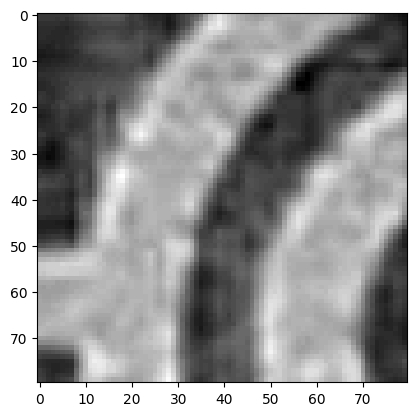

In [77]:
plt.imshow(x, cmap='gray')

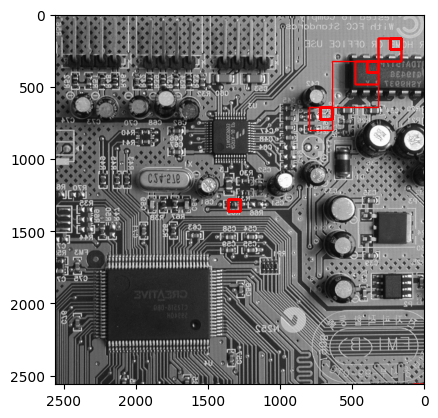

In [78]:
# display quadtree
quadtree.display()